<a href="https://colab.research.google.com/github/Belalaskaik/Active-Directory-Wordlists/blob/master/Pairs_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statsmodels

Statsmodels is a Python module that allows users to explore data, estimate statistical models, and perform statistical tests. An extensive list of descriptive statistics, statistical tests, plotting functions, and result statistics are available for different types of data and each estimator.

Library documentation: <a>http://statsmodels.sourceforge.net/</a>

# **Libraries Used**

In [ ]:
# needed to display the graphs
%matplotlib inline
from pylab import *

In [ ]:
import numpy as np
import yfinance as yf
yf.pdr_override()
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm
import scipy.optimize as spop
from scipy.stats import linregress as lg
from statsmodels.sandbox.regression.predstd import wls_prediction_std
np.random.seed(9876789)

# **Stocks Returns**

In [ ]:
stockPair = ['ADBE','ADSK']
end = dt.datetime.now()
start = dt.datetime(2014,12,30)

data = pd.DataFrame()
returns = pd.DataFrame()
for stock in stockPair:
  prices = yf.download(stock, start, end)
  data[stock] = prices['Adj Close']
  #Returns = (Price(t) / Price(t-1)) - 1 || t = current day, t-1 = previous day
  returns[stock] = np.append(data[stock][1:].reset_index(drop=True)/data[stock][:-1].reset_index(drop = True) -1, 0)
  returns.index = data.index



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


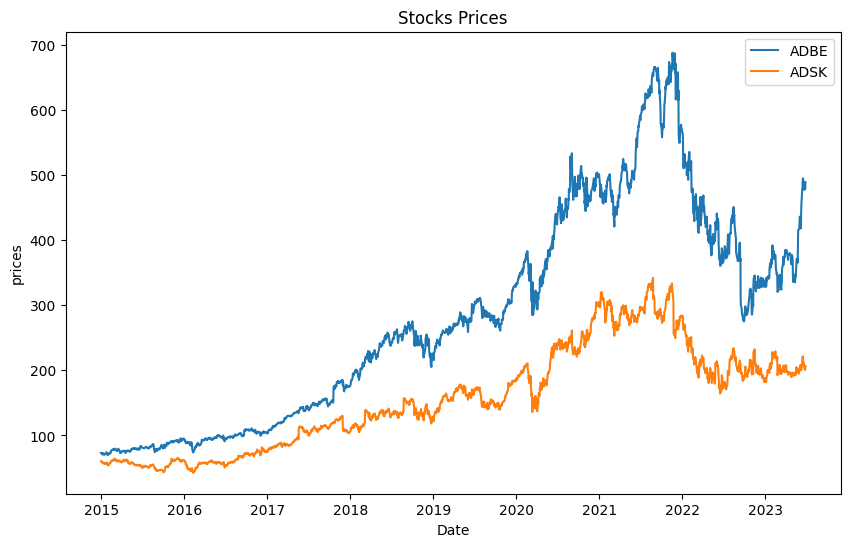

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['ADBE'], label='ADBE')
plt.plot(data.index, data['ADSK'], label='ADSK')

plt.xlabel('Date')  # Add x-axis label
plt.ylabel('prices')  # Add y-axis label

plt.title('Stocks Prices')
plt.legend()
plt.show()


In [ ]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test for ADBE stock returns
result_adbe = adfuller(returns['ADBE'].dropna())
print(f'ADF test for ADBE stock returns:')
print(f'ADF Statistic: {result_adbe[0]}')
print(f'p-value: {result_adbe[1]}')
print(f'Critical Values:')
for key, value in result_adbe[4].items():
    print(f'  {key}: {value}')

# Perform ADF test for ADSK stock returns
result_adsk = adfuller(returns['ADSK'].dropna())
print(f'\nADF test for ADSK stock returns:')
print(f'ADF Statistic: {result_adsk[0]}')
print(f'p-value: {result_adsk[1]}')
print(f'Critical Values:')
for key, value in result_adsk[4].items():
    print(f'  {key}: {value}')


ADF test for ADBE stock returns:
ADF Statistic: -15.60362899880607
p-value: 1.816167581546873e-28
Critical Values:
  1%: -3.433426694407439
  5%: -2.8628991628306677
  10%: -2.567493552640412

ADF test for ADSK stock returns:
ADF Statistic: -17.595533299599786
p-value: 3.944607198147435e-30
Critical Values:
  1%: -3.4334252475234646
  5%: -2.8628985239834686
  10%: -2.567493212493555


# **Experimenting using Static thresholds**






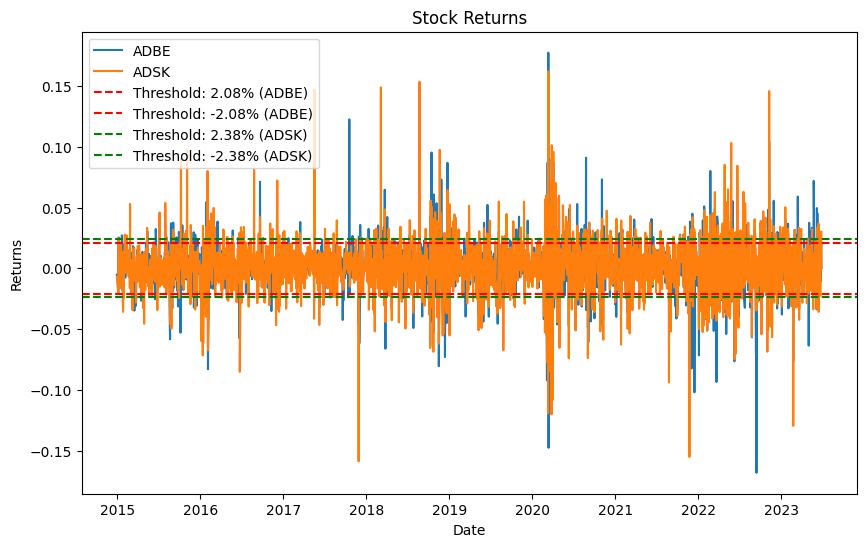

In [ ]:
#S.D. for all returns

threshold1 = returns['ADBE'].std()
threshold2 = returns['ADSK'].std()

plt.figure(figsize=(10, 6))
plt.plot(returns.index, returns['ADBE'], label='ADBE')
plt.plot(returns.index, returns['ADSK'], label='ADSK')

# Plotting threshold lines
plt.axhline(threshold1, color='red', linestyle='--', label=f'Threshold: {threshold1:.2%} (ADBE)')
plt.axhline(-threshold1, color='red', linestyle='--', label=f'Threshold: {-threshold1:.2%} (ADBE)')
plt.axhline(threshold2, color='green', linestyle='--', label=f'Threshold: {threshold2:.2%} (ADSK)')
plt.axhline(-threshold2, color='green', linestyle='--', label=f'Threshold: {-threshold2:.2%} (ADSK)')

plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Stock Returns')
plt.legend()
plt.show()


# **Using Rolling Window for a Dynamic Threshold**

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
             ADBE   ADSK
Date                    
2023-06-20  Short   None
2023-06-21   Long  Short
2023-06-22  Short   None
2023-06-23   None   Long
2023-06-26  Short   None
2023-06-27  Short   None


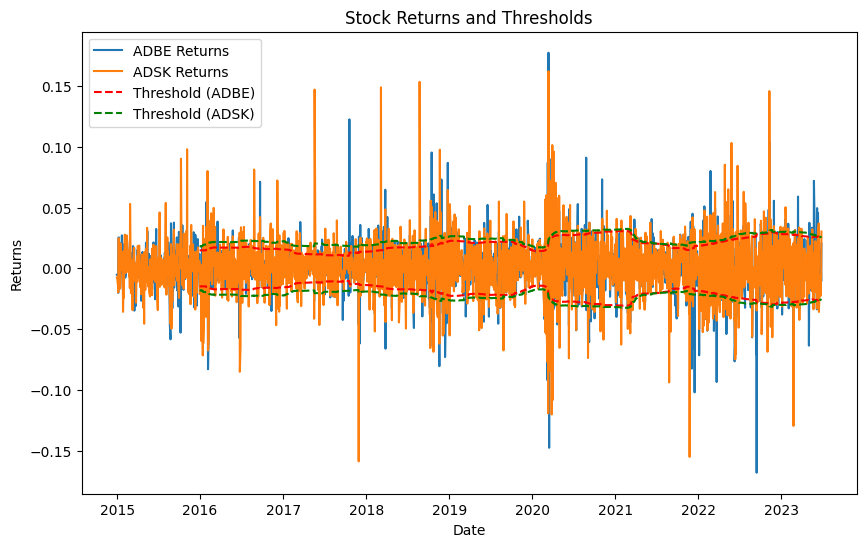

In [ ]:
stockPair = ['ADBE', 'ADSK']
end = dt.datetime.now()
start = dt.datetime(2014, 12, 30)
window = 252

data = pd.DataFrame()
returns = pd.DataFrame()
thresholds = pd.DataFrame()

# Download stock data
for stock in stockPair:
    prices = yf.download(stock, start, end)
    data[stock] = prices['Adj Close']

# Calculate returns using pandas:
# Equation for each day is (current - previous/previous) = returns
for stock in stockPair:
    returns[stock] = data[stock].pct_change()

# Calculate rolling threshold:
# Dynamically changing threshold based on window of observations
for stock in stockPair:
    thresholds[stock] = returns[stock].rolling(window).std()


def pairs_trading_strategy(returns, thresholds):
    positions = pd.DataFrame(index=returns.index)
    positions['ADBE'] = np.nan
    positions['ADSK'] = np.nan

    for i in range(window, len(returns)):
        returns_pct = returns.iloc[i]

        if returns_pct['ADBE'] > thresholds['ADBE'].iloc[i] and returns_pct['ADSK'] < -thresholds['ADSK'].iloc[i]:
            positions.at[returns.index[i], 'ADBE'] = 'Short'
            positions.at[returns.index[i], 'ADSK'] = 'Long'
        elif returns_pct['ADBE'] < -thresholds['ADBE'].iloc[i] and returns_pct['ADSK'] > thresholds['ADSK'].iloc[i]:
            positions.at[returns.index[i], 'ADBE'] = 'Long'
            positions.at[returns.index[i], 'ADSK'] = 'Short'
        elif returns_pct['ADBE'] > thresholds['ADBE'].iloc[i] and returns_pct['ADSK'] > thresholds['ADSK'].iloc[i]:
            positions.at[returns.index[i], 'ADBE'] = 'None'
            positions.at[returns.index[i], 'ADSK'] = 'Long'
        elif returns_pct['ADBE'] < -thresholds['ADBE'].iloc[i] and returns_pct['ADSK'] < -thresholds['ADSK'].iloc[i]:
            positions.at[returns.index[i], 'ADBE'] = 'Short'
            positions.at[returns.index[i], 'ADSK'] = 'None'
        else:
            positions.at[returns.index[i], 'ADBE'] = 'None'
            positions.at[returns.index[i], 'ADSK'] = 'None'

    return positions

# Call the function
positions = pairs_trading_strategy(returns.pct_change(), thresholds)

# Print the positions dataframe
print(positions.tail(6))

# Plot returns and threshold
plt.figure(figsize=(10, 6))
plt.plot(returns.index, returns['ADBE'], label='ADBE Returns')
plt.plot(returns.index, returns['ADSK'], label='ADSK Returns')

# Plot threshold lines
plt.plot(returns.index, thresholds['ADBE'], color='red', linestyle='--', label='Threshold (ADBE)')
plt.plot(returns.index, -thresholds['ADBE'], color='red', linestyle='--')
plt.plot(returns.index, thresholds['ADSK'], color='green', linestyle='--', label='Threshold (ADSK)')
plt.plot(returns.index, -thresholds['ADSK'], color='green', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Stock Returns and Thresholds')
plt.legend()
plt.show()
# Save positions to CSV
positions.to_csv('positions.csv')



In [ ]:
thresholds

,ADBE,ADSK
Date,,
2014-12-30,NaN,NaN
2014-12-31,NaN,NaN
2015-01-02,NaN,NaN
2015-01-05,NaN,NaN
2015-01-06,NaN,NaN
...,...,...
2023-06-21,0.025578,0.025868
2023-06-22,0.025576,0.025869
2023-06-23,0.025589,0.025900


In [ ]:
output_file = 'positions.csv'

# Save the positions dataframe to CSV
positions.to_csv(output_file)


In [ ]:
def plot_pairs(data1, data2):
  fig, (ax1, ax2) = plt.subplots(2)
  fig.suptitle('Pair of Stocks')
  ax1.plot(data1)
  ax2.plot(data2)
  plt.show()

def scatter(data1, data2):
  plt.scatter(data1.values, data2.values)
  plt.show()

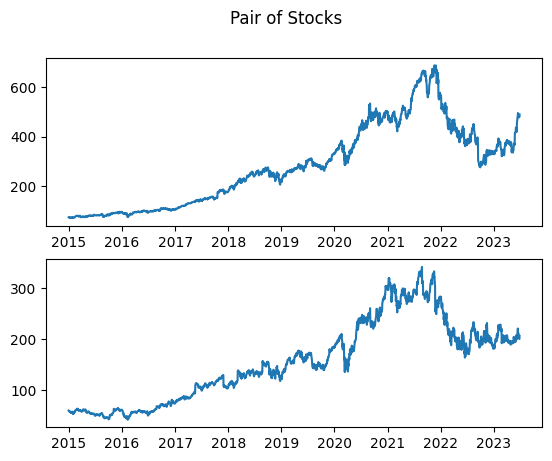

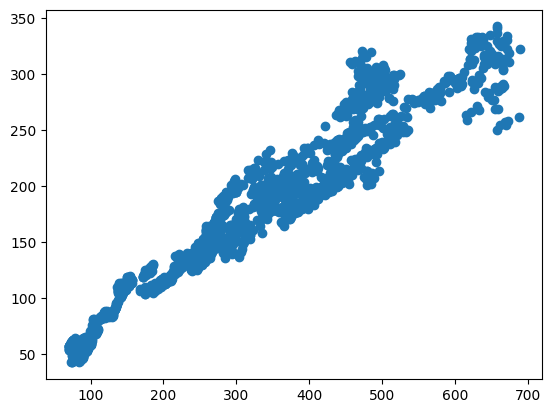

In [ ]:
gross_returns = np.array([])
net_returns = np.array([])
t_s = np.array([])
stock1 = stockPair[0]
stock2 = stockPair[1]
plot_pairs(data[stock1], data[stock2])
scatter(data[stock1], data[stock2])

In [ ]:
result = lg(data[stock1].values, data[stock2].values)
residuals = data[stock1] - result.slope * data[stock2]
adf = ts.adfuller(residuals)

In [ ]:
print(adf)
print(f'\nADF test for ADSK stock returns:')
print(f'ADF Statistic: {adf[0]}')
print(f'p-value: {adf[1]}')
print(f'Critical Values:')
for key, value in adf[4].items():
    print(f'  {key}: {value}')


(-1.0672420676565642, 0.7279570891630806, 9, 2127, {'1%': -3.4334281426535553, '5%': -2.862899802278988, '10%': -2.5674938931073803}, 13716.911058129353)

ADF test for ADSK stock returns:
ADF Statistic: -1.0672420676565642
p-value: 0.7279570891630806
Critical Values:
  1%: -3.4334281426535553
  5%: -2.862899802278988
  10%: -2.5674938931073803
